In [1]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [2]:
import keras

import matplotlib.pyplot as plt
%matplotlib inline

from keras.models import Sequential
from keras.layers import LSTM, GRU, Conv1D, MaxPooling1D, Flatten, Dense
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

## Start Here 

In [3]:
## Cek Jumlah Files
def count_files(datasetFolders):
    paths = ['abnormal', 'normal']
    for path in paths:
        folder_path = os.path.join(datasetFolders, path)
        num_files = sum(1 for item in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, item)))
        print(f"Jumlah file di folder '{path}': {num_files}")

count_files('./readyToUsed')

Jumlah file di folder 'abnormal': 1000
Jumlah file di folder 'normal': 1000


In [4]:
# Untuk mengambil dan memberikan label dari data
def load_data(folder_path):
    data = []   # Untuk menyimpan data
    labels = [] # Untuk menyimpan label
    
    # Iterasi melalui setiap folder dalam folder_path
    for label in os.listdir(folder_path):
        label_folder_path = os.path.join(folder_path, label)
        
        # Pastikan itu adalah direktori
        if os.path.isdir(label_folder_path):
            label_data = []  # Untuk menyimpan data untuk label tertentu
            
            # Iterasi melalui setiap file dalam label_folder_path
            for file_name in os.listdir(label_folder_path):
                if file_name.endswith('.npy'):  # Hanya memproses file .npy
                    file_path = os.path.join(label_folder_path, file_name)
                    # Memuat data dari file .npy
                    label_data.append(np.load(file_path))
            
            # Menambahkan data dan label untuk label tertentu
            data.extend(label_data)
            if label == 'normal':
                # Label 0 untuk normal
                labels.extend([0] * len(label_data))  
            else:
                # Label 1 untuk abnormal
                labels.extend([1] * len(label_data))  
    
    return np.array(data), np.array(labels)

# Memuat data dari folder readyToUsed
data_folder = "./readyToUsed/"
X, y = load_data(data_folder)

# Memisahkan data menjadi set pelatihan dan set validasi
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

# Menyesuaikan ukuran data untuk model LSTM dan GRU (menambahkan dimensi waktu)
X_train = np.expand_dims(X_train, axis=1)  # Menambah dimensi waktu di posisi kedua
X_valid = np.expand_dims(X_valid, axis=1)

# Normalisasi data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_valid = scaler.transform(X_valid.reshape(-1, X_valid.shape[-1])).reshape(X_valid.shape)

# Menampilkan ukuran setiap bagian data
print("Ukuran set pelatihan X:", X_train.shape)
print("Ukuran set pelatihan y:", y_train.shape)
print("Ukuran set validasi X:", X_valid.shape)
print("Ukuran set validasi y:", y_valid.shape)

Ukuran set pelatihan X: (1600, 1, 30000)
Ukuran set pelatihan y: (1600,)
Ukuran set validasi X: (400, 1, 30000)
Ukuran set validasi y: (400,)


## Build a Model Function 

In [5]:
def performsBaseModel(model, lr, epochs, X_val, y_val):
    if not isinstance(lr, (int, float)) and lr == 'auto':
        optimizer = Adam()
        reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                      patience=2,   # val_loss tidak mengalami penurunan dalam 2 epoch berturut-turut.
                                      factor=0.01,  # learning rate akan berkurang sebanyak 0.01
                                      min_lr=0.0001
                                     )
        
        model.compile(optimizer=optimizer, 
                      loss='binary_crossentropy', 
                      metrics=['accuracy'])
        
        history = model.fit(X_train, 
                            y_train, 
                            epochs=epochs, 
                            validation_data=(X_val, y_val), 
                            callbacks=[reduce_lr]
                           )
        
    else:
        optimizer = Adam(learning_rate=lr)
        model.compile(optimizer=optimizer, 
                      loss='binary_crossentropy', 
                      metrics=['accuracy']
                     )

        history = model.fit(X_train, 
                            y_train, 
                            epochs=epochs,
                            validation_data=(X_val, y_val)
                           )
    
    
    print('Accuracy', history.history['accuracy'])
    print('Val Accuracy', history.history['val_accuracy'])
    print('Loss', history.history['loss'])
    print('Val Loss', history.history['val_loss'])
    
    # Buat subplots
    fig, axs = plt.subplots(2)

    # Plot training & validation accuracy values
    axs[0].plot(history.history['accuracy'], label='Train')
    axs[0].plot(history.history['val_accuracy'], label='Validation')
    axs[0].set_title('Model accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].legend(loc='upper left')

    # Plot training & validation loss values
    axs[1].plot(history.history['loss'], label='Train')
    axs[1].plot(history.history['val_loss'], label='Validation')
    axs[1].set_title('Model loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].legend(loc='upper left')
    
    # Sesuaikan tata letak
    plt.show()

    # Membuat prediksi pada data validasi
    y_pred = model.predict(X_valid)
    
    # Konversi nilai probabilitas menjadi label biner (0 atau 1)
    y_pred_binary = (y_pred > 0.5)
    
    # Menampilkan confusion matrix
    print("Confusion Matrix:")
    print(confusion_matrix(y_valid, y_pred_binary))

    # Menampilkan classification report
    print("Classification Report:")
    print(classification_report(y_valid, y_pred_binary))

In [6]:
# Long Short Term Memory
def baseModel_LSTM(X_train, y_train, X_val, y_val, lr, epochs):
    model = Sequential([
        LSTM(units=128, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True),
        LSTM(units=64),
        Dense(units=32, activation='relu'),
        Dense(units=1, activation='sigmoid')
    ])

    performsBaseModel(model, lr, epochs, X_val, y_val)


# Gated Recurrent Unit
def baseModel_GRU(X_train, y_train, X_val, y_val, lr, epochs):
    model = Sequential([
        GRU(units=128, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True),
        GRU(units=64),
        Dense(units=32, activation='relu'),
        Dense(units=1, activation='sigmoid')
    ])
    
    performsBaseModel(model, lr, epochs, X_val, y_val)


# Temporal Convolutional Network
def baseModel_TCN(X_train, y_train, X_val, y_val, lr, epochs):
    model = Sequential([
        Conv1D(filters=128, kernel_size=3, activation='relu', padding='same', 
               input_shape=(X_train.shape[1], X_train.shape[2])),
        MaxPooling1D(pool_size=1),
        Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'),
        MaxPooling1D(pool_size=1),
        Flatten(),
        Dense(units=32, activation='relu'),
        Dense(units=1, activation='sigmoid')
    ])
    
    performsBaseModel(model, lr, epochs, X_val, y_val)

Epoch 1/10
50/50 [==============================] - 14s 204ms/step - loss: 0.5780 - accuracy: 0.6975 - val_loss: 0.5103 - val_accuracy: 0.7500
Epoch 2/10
50/50 [==============================] - 8s 168ms/step - loss: 0.5025 - accuracy: 0.7837 - val_loss: 0.5249 - val_accuracy: 0.7650
Epoch 3/10
50/50 [==============================] - 8s 162ms/step - loss: 0.4849 - accuracy: 0.7788 - val_loss: 0.5446 - val_accuracy: 0.7775
Epoch 4/10
50/50 [==============================] - 8s 163ms/step - loss: 0.4675 - accuracy: 0.7731 - val_loss: 0.5018 - val_accuracy: 0.7550
Epoch 5/10
50/50 [==============================] - 8s 159ms/step - loss: 0.4778 - accuracy: 0.7919 - val_loss: 0.4678 - val_accuracy: 0.7750
Epoch 6/10
50/50 [==============================] - 8s 159ms/step - loss: 0.4593 - accuracy: 0.7875 - val_loss: 0.4905 - val_accuracy: 0.7575
Epoch 7/10
50/50 [==============================] - 8s 167ms/step - loss: 0.4453 - accuracy: 0.7850 - val_loss: 0.5316 - val_accuracy: 0.7600
Epoch

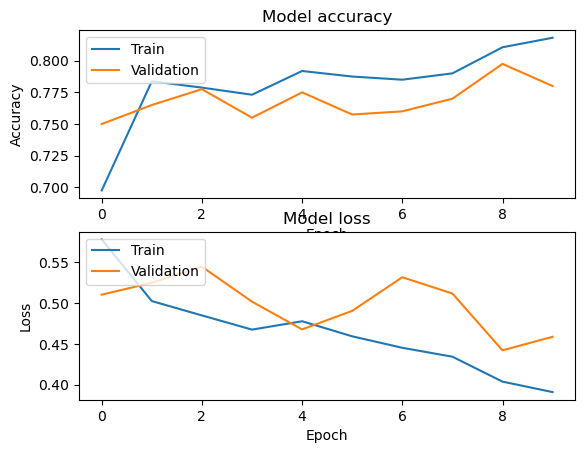

13/13 [==============================] - 1s 13ms/step
Confusion Matrix:
[[134  67]
 [ 21 178]]
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.67      0.75       201
           1       0.73      0.89      0.80       199

    accuracy                           0.78       400
   macro avg       0.80      0.78      0.78       400
weighted avg       0.80      0.78      0.78       400



In [13]:
# LSTM with learning rate (0.01)
baseModel_LSTM(X_train, y_train, X_valid, y_valid, lr=0.01, epochs=10)

Epoch 1/10
50/50 [==============================] - 17s 228ms/step - loss: 0.5131 - accuracy: 0.7706 - val_loss: 0.4659 - val_accuracy: 0.8075
Epoch 2/10
50/50 [==============================] - 9s 183ms/step - loss: 0.3894 - accuracy: 0.8444 - val_loss: 0.4120 - val_accuracy: 0.8300
Epoch 3/10
50/50 [==============================] - 9s 188ms/step - loss: 0.3757 - accuracy: 0.8494 - val_loss: 0.3898 - val_accuracy: 0.8725
Epoch 4/10
50/50 [==============================] - 9s 183ms/step - loss: 0.3277 - accuracy: 0.8731 - val_loss: 0.3714 - val_accuracy: 0.8725
Epoch 5/10
50/50 [==============================] - 9s 182ms/step - loss: 0.2934 - accuracy: 0.8831 - val_loss: 0.4308 - val_accuracy: 0.8300
Epoch 6/10
50/50 [==============================] - 9s 188ms/step - loss: 0.2758 - accuracy: 0.8850 - val_loss: 0.3951 - val_accuracy: 0.8500
Epoch 7/10
50/50 [==============================] - 9s 185ms/step - loss: 0.2906 - accuracy: 0.8881 - val_loss: 0.3583 - val_accuracy: 0.8775
Epoch

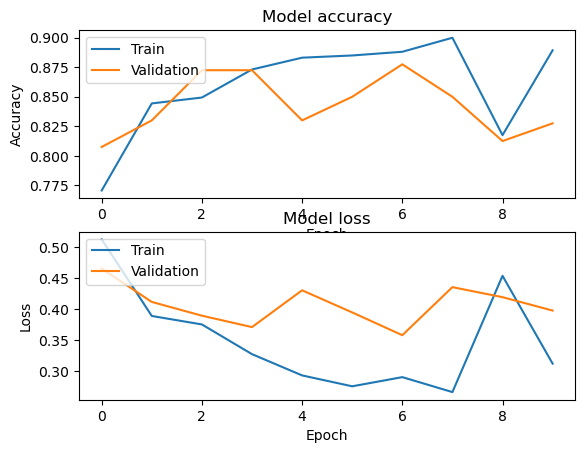

13/13 [==============================] - 1s 15ms/step
Confusion Matrix:
[[182  19]
 [ 50 149]]
Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.91      0.84       201
           1       0.89      0.75      0.81       199

    accuracy                           0.83       400
   macro avg       0.84      0.83      0.83       400
weighted avg       0.84      0.83      0.83       400



In [14]:
# LSTM with learning rate (0.001)
baseModel_LSTM(X_train, y_train, X_valid, y_valid, lr=0.001, epochs=10)

Epoch 1/10
50/50 [==============================] - 13s 197ms/step - loss: 0.5294 - accuracy: 0.7962 - val_loss: 0.4833 - val_accuracy: 0.8450
Epoch 2/10
50/50 [==============================] - 9s 172ms/step - loss: 0.3993 - accuracy: 0.8750 - val_loss: 0.3871 - val_accuracy: 0.8875
Epoch 3/10
50/50 [==============================] - 9s 177ms/step - loss: 0.3244 - accuracy: 0.8919 - val_loss: 0.3569 - val_accuracy: 0.8825
Epoch 4/10
50/50 [==============================] - 8s 164ms/step - loss: 0.2608 - accuracy: 0.9244 - val_loss: 0.3200 - val_accuracy: 0.9025
Epoch 5/10
50/50 [==============================] - 9s 175ms/step - loss: 0.2183 - accuracy: 0.9331 - val_loss: 0.2956 - val_accuracy: 0.9000
Epoch 6/10
50/50 [==============================] - 9s 175ms/step - loss: 0.1871 - accuracy: 0.9406 - val_loss: 0.3091 - val_accuracy: 0.8900
Epoch 7/10
50/50 [==============================] - 9s 171ms/step - loss: 0.1698 - accuracy: 0.9375 - val_loss: 0.2627 - val_accuracy: 0.9125
Epoch

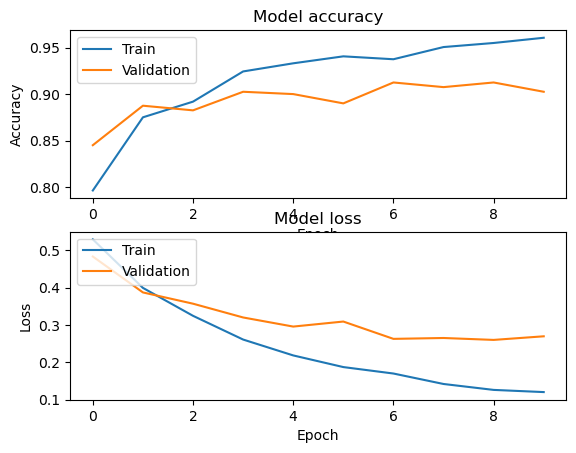

13/13 [==============================] - 1s 14ms/step
Confusion Matrix:
[[190  11]
 [ 28 171]]
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.95      0.91       201
           1       0.94      0.86      0.90       199

    accuracy                           0.90       400
   macro avg       0.91      0.90      0.90       400
weighted avg       0.91      0.90      0.90       400



In [15]:
# LSTM with learning rate (0.0001)
baseModel_LSTM(X_train, y_train, X_valid, y_valid, lr=0.0001, epochs=10)

Epoch 1/10
50/50 [==============================] - 14s 202ms/step - loss: 0.5006 - accuracy: 0.7744 - val_loss: 0.4295 - val_accuracy: 0.8525 - lr: 0.0010
Epoch 2/10
50/50 [==============================] - 9s 175ms/step - loss: 0.3926 - accuracy: 0.8413 - val_loss: 0.4193 - val_accuracy: 0.8300 - lr: 0.0010
Epoch 3/10
50/50 [==============================] - 8s 170ms/step - loss: 0.3456 - accuracy: 0.8612 - val_loss: 0.4279 - val_accuracy: 0.8250 - lr: 0.0010
Epoch 4/10
50/50 [==============================] - 9s 170ms/step - loss: 0.3270 - accuracy: 0.8687 - val_loss: 0.4359 - val_accuracy: 0.8175 - lr: 0.0010
Epoch 5/10
50/50 [==============================] - 9s 178ms/step - loss: 0.3056 - accuracy: 0.8744 - val_loss: 0.3623 - val_accuracy: 0.8600 - lr: 1.0000e-04
Epoch 6/10
50/50 [==============================] - 8s 165ms/step - loss: 0.2752 - accuracy: 0.8831 - val_loss: 0.3529 - val_accuracy: 0.8650 - lr: 1.0000e-04
Epoch 7/10
50/50 [==============================] - 8s 167ms/

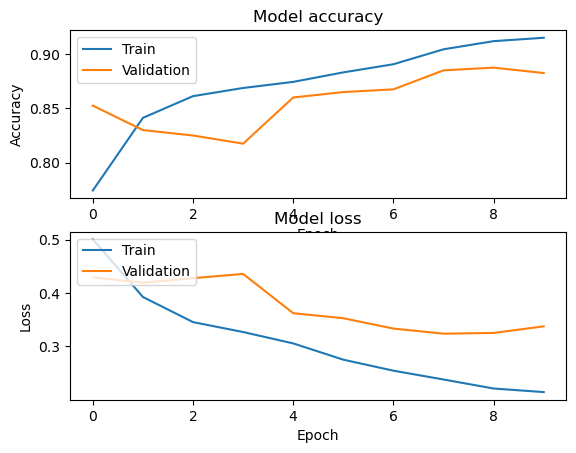

13/13 [==============================] - 1s 13ms/step
Confusion Matrix:
[[183  18]
 [ 29 170]]
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.91      0.89       201
           1       0.90      0.85      0.88       199

    accuracy                           0.88       400
   macro avg       0.88      0.88      0.88       400
weighted avg       0.88      0.88      0.88       400



In [20]:
# LSTM with learning rate (auto)
baseModel_LSTM(X_train, y_train, X_valid, y_valid, lr='auto', epochs=10)

Epoch 1/10
50/50 [==============================] - 11s 146ms/step - loss: 0.5561 - accuracy: 0.7369 - val_loss: 0.5066 - val_accuracy: 0.7725
Epoch 2/10
50/50 [==============================] - 6s 128ms/step - loss: 0.4983 - accuracy: 0.7725 - val_loss: 0.5145 - val_accuracy: 0.7675
Epoch 3/10
50/50 [==============================] - 6s 125ms/step - loss: 0.4766 - accuracy: 0.7756 - val_loss: 0.4974 - val_accuracy: 0.7650
Epoch 4/10
50/50 [==============================] - 6s 124ms/step - loss: 0.5034 - accuracy: 0.7681 - val_loss: 0.4959 - val_accuracy: 0.7950
Epoch 5/10
50/50 [==============================] - 6s 124ms/step - loss: 0.4558 - accuracy: 0.7831 - val_loss: 0.4742 - val_accuracy: 0.7975
Epoch 6/10
50/50 [==============================] - 6s 124ms/step - loss: 0.4221 - accuracy: 0.8075 - val_loss: 0.4676 - val_accuracy: 0.8025
Epoch 7/10
50/50 [==============================] - 6s 125ms/step - loss: 0.4445 - accuracy: 0.8019 - val_loss: 0.4982 - val_accuracy: 0.8050
Epoch

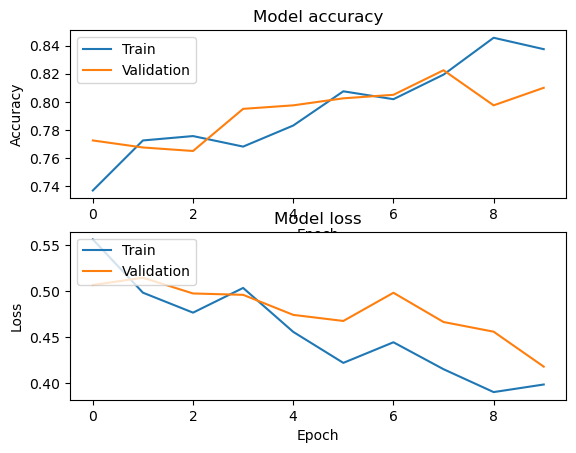

13/13 [==============================] - 1s 11ms/step
Confusion Matrix:
[[172  29]
 [ 47 152]]
Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.86      0.82       201
           1       0.84      0.76      0.80       199

    accuracy                           0.81       400
   macro avg       0.81      0.81      0.81       400
weighted avg       0.81      0.81      0.81       400



In [21]:
# GRU with learning rate (0.01)
baseModel_GRU(X_train, y_train, X_valid, y_valid, lr=0.01, epochs=10)

Epoch 1/10
50/50 [==============================] - 11s 160ms/step - loss: 0.4644 - accuracy: 0.7931 - val_loss: 0.4349 - val_accuracy: 0.8025
Epoch 2/10
50/50 [==============================] - 8s 160ms/step - loss: 0.3698 - accuracy: 0.8537 - val_loss: 0.4166 - val_accuracy: 0.8325
Epoch 3/10
50/50 [==============================] - 7s 145ms/step - loss: 0.3475 - accuracy: 0.8719 - val_loss: 0.4061 - val_accuracy: 0.8575
Epoch 4/10
50/50 [==============================] - 7s 139ms/step - loss: 0.3163 - accuracy: 0.8800 - val_loss: 0.3831 - val_accuracy: 0.8650
Epoch 5/10
50/50 [==============================] - 7s 140ms/step - loss: 0.3231 - accuracy: 0.8781 - val_loss: 0.3819 - val_accuracy: 0.8675
Epoch 6/10
50/50 [==============================] - 7s 140ms/step - loss: 0.2959 - accuracy: 0.8806 - val_loss: 0.3979 - val_accuracy: 0.8375
Epoch 7/10
50/50 [==============================] - 7s 140ms/step - loss: 0.3040 - accuracy: 0.8662 - val_loss: 0.3636 - val_accuracy: 0.8725
Epoch

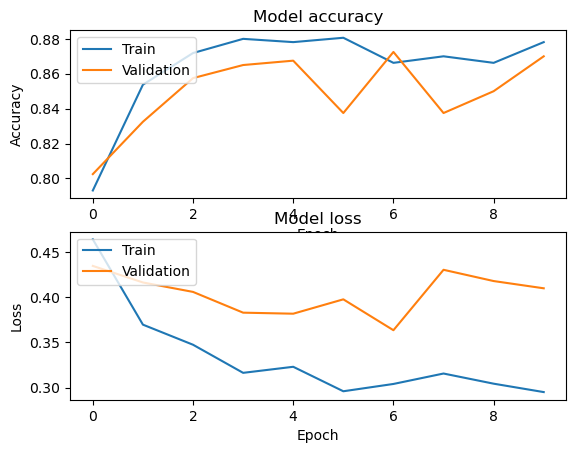

13/13 [==============================] - 1s 11ms/step
Confusion Matrix:
[[180  21]
 [ 31 168]]
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.90      0.87       201
           1       0.89      0.84      0.87       199

    accuracy                           0.87       400
   macro avg       0.87      0.87      0.87       400
weighted avg       0.87      0.87      0.87       400



In [22]:
# GRU with learning rate (0.001)
baseModel_GRU(X_train, y_train, X_valid, y_valid, lr=0.001, epochs=10)

Epoch 1/10
50/50 [==============================] - 12s 159ms/step - loss: 0.4510 - accuracy: 0.8213 - val_loss: 0.3960 - val_accuracy: 0.8575
Epoch 2/10
50/50 [==============================] - 7s 142ms/step - loss: 0.3129 - accuracy: 0.8956 - val_loss: 0.3332 - val_accuracy: 0.9050
Epoch 3/10
50/50 [==============================] - 7s 134ms/step - loss: 0.2499 - accuracy: 0.9212 - val_loss: 0.3065 - val_accuracy: 0.9125
Epoch 4/10
50/50 [==============================] - 7s 133ms/step - loss: 0.2069 - accuracy: 0.9319 - val_loss: 0.2915 - val_accuracy: 0.9000
Epoch 5/10
50/50 [==============================] - 7s 137ms/step - loss: 0.1775 - accuracy: 0.9375 - val_loss: 0.2999 - val_accuracy: 0.8900
Epoch 6/10
50/50 [==============================] - 7s 134ms/step - loss: 0.1539 - accuracy: 0.9475 - val_loss: 0.2818 - val_accuracy: 0.9025
Epoch 7/10
50/50 [==============================] - 7s 137ms/step - loss: 0.1289 - accuracy: 0.9600 - val_loss: 0.2653 - val_accuracy: 0.9075
Epoch

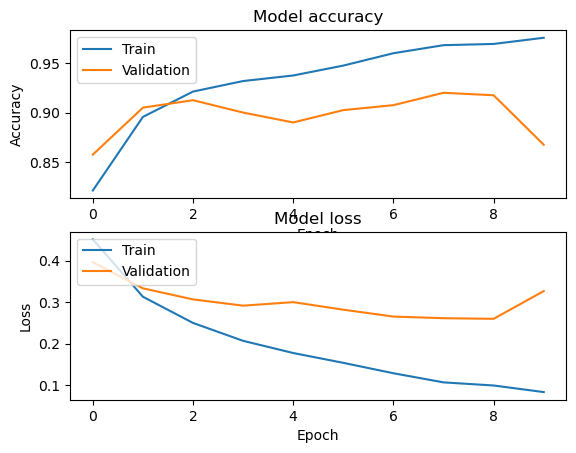

13/13 [==============================] - 1s 13ms/step
Confusion Matrix:
[[192   9]
 [ 44 155]]
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.96      0.88       201
           1       0.95      0.78      0.85       199

    accuracy                           0.87       400
   macro avg       0.88      0.87      0.87       400
weighted avg       0.88      0.87      0.87       400



In [23]:
# GRU with learning rate (0.0001)
baseModel_GRU(X_train, y_train, X_valid, y_valid, lr=0.0001, epochs=10)

Epoch 1/10
50/50 [==============================] - 13s 156ms/step - loss: 0.4840 - accuracy: 0.7912 - val_loss: 0.4385 - val_accuracy: 0.8275 - lr: 0.0010
Epoch 2/10
50/50 [==============================] - 7s 138ms/step - loss: 0.3678 - accuracy: 0.8581 - val_loss: 0.3866 - val_accuracy: 0.8525 - lr: 0.0010
Epoch 3/10
50/50 [==============================] - 7s 132ms/step - loss: 0.3659 - accuracy: 0.8544 - val_loss: 0.4907 - val_accuracy: 0.8000 - lr: 0.0010
Epoch 4/10
50/50 [==============================] - 7s 134ms/step - loss: 0.3438 - accuracy: 0.8606 - val_loss: 0.3817 - val_accuracy: 0.8800 - lr: 0.0010
Epoch 5/10
50/50 [==============================] - 7s 131ms/step - loss: 0.2903 - accuracy: 0.8825 - val_loss: 0.3859 - val_accuracy: 0.8400 - lr: 0.0010
Epoch 6/10
50/50 [==============================] - 7s 135ms/step - loss: 0.2608 - accuracy: 0.8956 - val_loss: 0.3515 - val_accuracy: 0.8900 - lr: 0.0010
Epoch 7/10
50/50 [==============================] - 7s 135ms/step - l

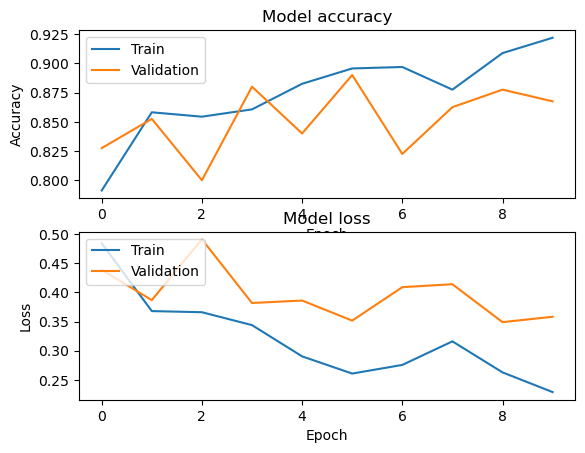

13/13 [==============================] - 1s 12ms/step
Confusion Matrix:
[[185  16]
 [ 37 162]]
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.92      0.87       201
           1       0.91      0.81      0.86       199

    accuracy                           0.87       400
   macro avg       0.87      0.87      0.87       400
weighted avg       0.87      0.87      0.87       400



In [24]:
# GRU with learning rate (auto)
baseModel_GRU(X_train, y_train, X_valid, y_valid, lr='auto', epochs=10)

Epoch 1/10
50/50 [==============================] - 34s 656ms/step - loss: 6.4776 - accuracy: 0.7169 - val_loss: 1.3440 - val_accuracy: 0.8100
Epoch 2/10
50/50 [==============================] - 32s 637ms/step - loss: 1.0563 - accuracy: 0.8150 - val_loss: 0.6979 - val_accuracy: 0.8650
Epoch 3/10
50/50 [==============================] - 32s 648ms/step - loss: 0.6862 - accuracy: 0.8531 - val_loss: 1.1860 - val_accuracy: 0.8250
Epoch 4/10
50/50 [==============================] - 32s 631ms/step - loss: 0.3591 - accuracy: 0.8925 - val_loss: 0.6006 - val_accuracy: 0.8725
Epoch 5/10
50/50 [==============================] - 30s 598ms/step - loss: 0.1870 - accuracy: 0.9356 - val_loss: 0.5310 - val_accuracy: 0.8975
Epoch 6/10
50/50 [==============================] - 30s 601ms/step - loss: 0.1327 - accuracy: 0.9513 - val_loss: 0.6436 - val_accuracy: 0.8975
Epoch 7/10
50/50 [==============================] - 30s 600ms/step - loss: 0.1085 - accuracy: 0.9656 - val_loss: 0.5015 - val_accuracy: 0.9100

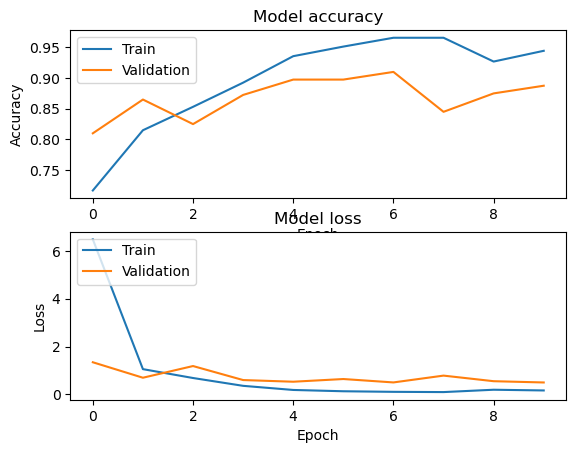

13/13 [==============================] - 0s 10ms/step
Confusion Matrix:
[[181  20]
 [ 25 174]]
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.90      0.89       201
           1       0.90      0.87      0.89       199

    accuracy                           0.89       400
   macro avg       0.89      0.89      0.89       400
weighted avg       0.89      0.89      0.89       400



In [35]:
# TCN with learning rate (0.01)
baseModel_TCN(X_train, y_train, X_valid, y_valid, lr=0.01, epochs=10)

Epoch 1/10
50/50 [==============================] - 31s 610ms/step - loss: 0.9637 - accuracy: 0.7575 - val_loss: 0.5833 - val_accuracy: 0.8150
Epoch 2/10
50/50 [==============================] - 30s 598ms/step - loss: 0.4988 - accuracy: 0.8556 - val_loss: 0.6674 - val_accuracy: 0.8500
Epoch 3/10
50/50 [==============================] - 30s 593ms/step - loss: 0.2664 - accuracy: 0.9206 - val_loss: 0.4460 - val_accuracy: 0.8825
Epoch 4/10
50/50 [==============================] - 30s 596ms/step - loss: 0.2251 - accuracy: 0.9444 - val_loss: 0.4705 - val_accuracy: 0.9050
Epoch 5/10
50/50 [==============================] - 30s 596ms/step - loss: 0.1273 - accuracy: 0.9594 - val_loss: 0.4710 - val_accuracy: 0.8700
Epoch 6/10
50/50 [==============================] - 30s 599ms/step - loss: 0.1069 - accuracy: 0.9706 - val_loss: 0.5085 - val_accuracy: 0.8750
Epoch 7/10
50/50 [==============================] - 30s 594ms/step - loss: 0.0561 - accuracy: 0.9831 - val_loss: 0.6114 - val_accuracy: 0.9025

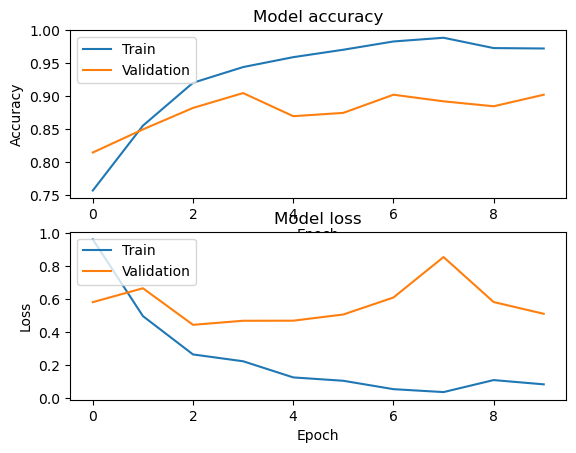

13/13 [==============================] - 0s 9ms/step
Confusion Matrix:
[[183  18]
 [ 21 178]]
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.91      0.90       201
           1       0.91      0.89      0.90       199

    accuracy                           0.90       400
   macro avg       0.90      0.90      0.90       400
weighted avg       0.90      0.90      0.90       400



In [36]:
# TCN with learning rate (0.001)
baseModel_TCN(X_train, y_train, X_valid, y_valid, lr=0.001, epochs=10)

Epoch 1/10
50/50 [==============================] - 33s 644ms/step - loss: 0.4645 - accuracy: 0.7994 - val_loss: 0.4120 - val_accuracy: 0.8600
Epoch 2/10
50/50 [==============================] - 31s 620ms/step - loss: 0.2893 - accuracy: 0.8856 - val_loss: 0.3315 - val_accuracy: 0.8875
Epoch 3/10
50/50 [==============================] - 34s 686ms/step - loss: 0.1939 - accuracy: 0.9388 - val_loss: 0.3213 - val_accuracy: 0.8850
Epoch 4/10
50/50 [==============================] - 33s 669ms/step - loss: 0.1395 - accuracy: 0.9525 - val_loss: 0.3339 - val_accuracy: 0.8925
Epoch 5/10
50/50 [==============================] - 37s 737ms/step - loss: 0.0916 - accuracy: 0.9756 - val_loss: 0.3445 - val_accuracy: 0.8925
Epoch 6/10
50/50 [==============================] - 34s 675ms/step - loss: 0.0719 - accuracy: 0.9806 - val_loss: 0.3246 - val_accuracy: 0.9125
Epoch 7/10
50/50 [==============================] - 31s 614ms/step - loss: 0.0578 - accuracy: 0.9856 - val_loss: 0.3599 - val_accuracy: 0.9050

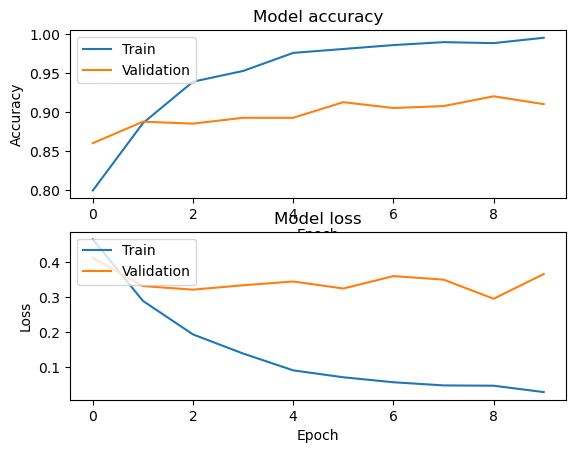

13/13 [==============================] - 0s 8ms/step
Confusion Matrix:
[[191  10]
 [ 26 173]]
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.95      0.91       201
           1       0.95      0.87      0.91       199

    accuracy                           0.91       400
   macro avg       0.91      0.91      0.91       400
weighted avg       0.91      0.91      0.91       400



In [37]:
# TCN with learning rate (0.0001)
baseModel_TCN(X_train, y_train, X_valid, y_valid, lr=0.0001, epochs=10)

Epoch 1/10
50/50 [==============================] - 31s 598ms/step - loss: 0.8714 - accuracy: 0.7738 - val_loss: 0.6333 - val_accuracy: 0.8475 - lr: 0.0010
Epoch 2/10
50/50 [==============================] - 30s 591ms/step - loss: 0.3754 - accuracy: 0.8850 - val_loss: 0.5430 - val_accuracy: 0.8525 - lr: 0.0010
Epoch 3/10
50/50 [==============================] - 30s 595ms/step - loss: 0.2181 - accuracy: 0.9219 - val_loss: 0.5235 - val_accuracy: 0.8625 - lr: 0.0010
Epoch 4/10
50/50 [==============================] - 31s 612ms/step - loss: 0.1296 - accuracy: 0.9525 - val_loss: 0.5336 - val_accuracy: 0.8725 - lr: 0.0010
Epoch 5/10
50/50 [==============================] - 33s 654ms/step - loss: 0.0771 - accuracy: 0.9731 - val_loss: 0.4769 - val_accuracy: 0.8850 - lr: 0.0010
Epoch 6/10
50/50 [==============================] - 31s 623ms/step - loss: 0.0876 - accuracy: 0.9725 - val_loss: 0.5292 - val_accuracy: 0.8975 - lr: 0.0010
Epoch 7/10
50/50 [==============================] - 30s 599ms/st

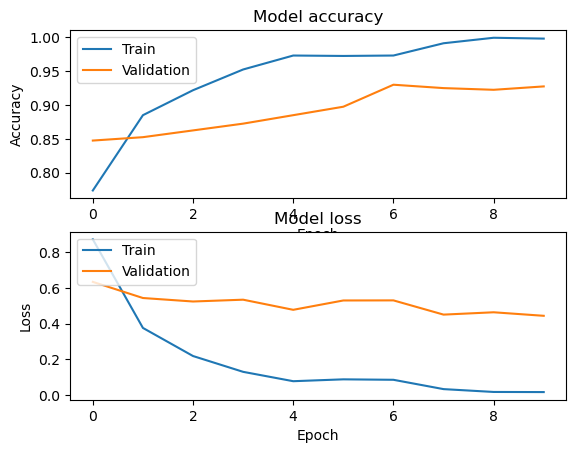

13/13 [==============================] - 0s 9ms/step
Confusion Matrix:
[[190  11]
 [ 18 181]]
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.95      0.93       201
           1       0.94      0.91      0.93       199

    accuracy                           0.93       400
   macro avg       0.93      0.93      0.93       400
weighted avg       0.93      0.93      0.93       400



In [38]:
# TCN with learning rate (auto)
baseModel_TCN(X_train, y_train, X_valid, y_valid, lr='auto', epochs=10)

## With Epoch = 20

Epoch 1/20
50/50 [==============================] - 12s 175ms/step - loss: 0.5124 - accuracy: 0.7681 - val_loss: 0.5324 - val_accuracy: 0.7475
Epoch 2/20
50/50 [==============================] - 9s 183ms/step - loss: 0.4950 - accuracy: 0.7819 - val_loss: 0.5226 - val_accuracy: 0.7625
Epoch 3/20
50/50 [==============================] - 8s 159ms/step - loss: 0.5043 - accuracy: 0.7694 - val_loss: 0.4803 - val_accuracy: 0.7925
Epoch 4/20
50/50 [==============================] - 8s 158ms/step - loss: 0.4800 - accuracy: 0.7688 - val_loss: 0.5075 - val_accuracy: 0.7500
Epoch 5/20
50/50 [==============================] - 8s 155ms/step - loss: 0.4544 - accuracy: 0.7856 - val_loss: 0.4949 - val_accuracy: 0.7575
Epoch 6/20
50/50 [==============================] - 8s 159ms/step - loss: 0.4287 - accuracy: 0.7844 - val_loss: 0.4603 - val_accuracy: 0.7875
Epoch 7/20
50/50 [==============================] - 9s 178ms/step - loss: 0.4198 - accuracy: 0.7950 - val_loss: 0.5557 - val_accuracy: 0.7275
Epoch

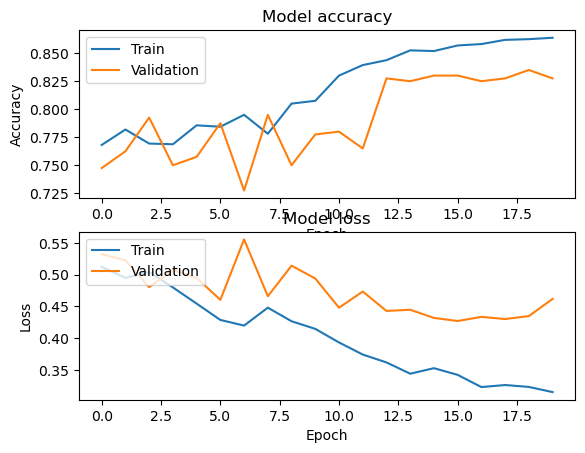

13/13 [==============================] - 1s 15ms/step
Confusion Matrix:
[[168  33]
 [ 36 163]]
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.84      0.83       201
           1       0.83      0.82      0.83       199

    accuracy                           0.83       400
   macro avg       0.83      0.83      0.83       400
weighted avg       0.83      0.83      0.83       400



In [40]:
# LSTM with learning rate (0.01)
baseModel_LSTM(X_train, y_train, X_valid, y_valid, lr=0.01, epochs=20)

Epoch 1/20
50/50 [==============================] - 15s 206ms/step - loss: 0.5011 - accuracy: 0.7844 - val_loss: 0.4552 - val_accuracy: 0.8000
Epoch 2/20
50/50 [==============================] - 8s 166ms/step - loss: 0.3754 - accuracy: 0.8481 - val_loss: 0.4158 - val_accuracy: 0.8175
Epoch 3/20
50/50 [==============================] - 8s 165ms/step - loss: 0.3462 - accuracy: 0.8687 - val_loss: 0.3700 - val_accuracy: 0.8800
Epoch 4/20
50/50 [==============================] - 8s 164ms/step - loss: 0.3232 - accuracy: 0.8694 - val_loss: 0.3825 - val_accuracy: 0.8650
Epoch 5/20
50/50 [==============================] - 9s 172ms/step - loss: 0.2840 - accuracy: 0.8875 - val_loss: 0.3169 - val_accuracy: 0.9000
Epoch 6/20
50/50 [==============================] - 9s 174ms/step - loss: 0.2991 - accuracy: 0.8875 - val_loss: 0.4008 - val_accuracy: 0.8525
Epoch 7/20
50/50 [==============================] - 9s 175ms/step - loss: 0.3226 - accuracy: 0.8531 - val_loss: 0.3834 - val_accuracy: 0.8575
Epoch

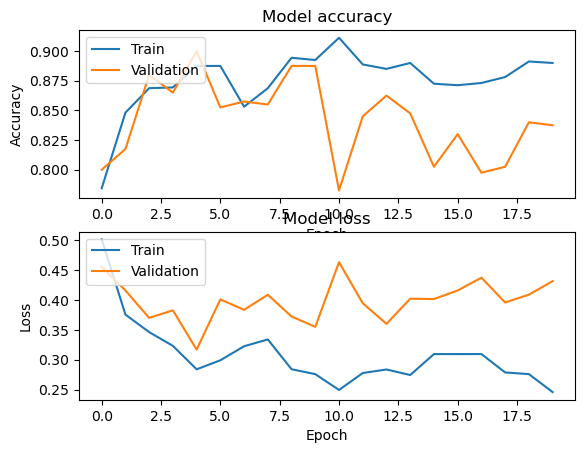

13/13 [==============================] - 1s 14ms/step
Confusion Matrix:
[[153  48]
 [ 17 182]]
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.76      0.82       201
           1       0.79      0.91      0.85       199

    accuracy                           0.84       400
   macro avg       0.85      0.84      0.84       400
weighted avg       0.85      0.84      0.84       400



In [41]:
# LSTM with learning rate (0.001)
baseModel_LSTM(X_train, y_train, X_valid, y_valid, lr=0.001, epochs=20)

Epoch 1/20
50/50 [==============================] - 16s 193ms/step - loss: 0.5324 - accuracy: 0.7931 - val_loss: 0.4627 - val_accuracy: 0.8700
Epoch 2/20
50/50 [==============================] - 8s 163ms/step - loss: 0.3994 - accuracy: 0.8794 - val_loss: 0.3830 - val_accuracy: 0.8925
Epoch 3/20
50/50 [==============================] - 9s 175ms/step - loss: 0.3152 - accuracy: 0.9100 - val_loss: 0.3381 - val_accuracy: 0.8975
Epoch 4/20
50/50 [==============================] - 9s 182ms/step - loss: 0.2564 - accuracy: 0.9225 - val_loss: 0.3080 - val_accuracy: 0.8975
Epoch 5/20
50/50 [==============================] - 8s 162ms/step - loss: 0.2148 - accuracy: 0.9269 - val_loss: 0.2900 - val_accuracy: 0.8975
Epoch 6/20
50/50 [==============================] - 8s 164ms/step - loss: 0.1789 - accuracy: 0.9406 - val_loss: 0.2900 - val_accuracy: 0.9000
Epoch 7/20
50/50 [==============================] - 8s 162ms/step - loss: 0.1579 - accuracy: 0.9463 - val_loss: 0.2686 - val_accuracy: 0.9025
Epoch

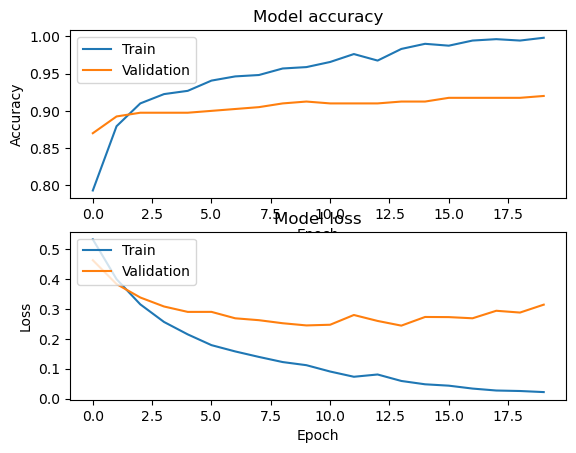

13/13 [==============================] - 1s 14ms/step
Confusion Matrix:
[[190  11]
 [ 21 178]]
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.95      0.92       201
           1       0.94      0.89      0.92       199

    accuracy                           0.92       400
   macro avg       0.92      0.92      0.92       400
weighted avg       0.92      0.92      0.92       400



In [42]:
# LSTM with learning rate (0.0001)
baseModel_LSTM(X_train, y_train, X_valid, y_valid, lr=0.0001, epochs=20)

Epoch 1/20
50/50 [==============================] - 14s 203ms/step - loss: 0.5253 - accuracy: 0.7506 - val_loss: 0.4625 - val_accuracy: 0.8125 - lr: 0.0010
Epoch 2/20
50/50 [==============================] - 9s 172ms/step - loss: 0.3900 - accuracy: 0.8400 - val_loss: 0.4238 - val_accuracy: 0.8175 - lr: 0.0010
Epoch 3/20
50/50 [==============================] - 8s 169ms/step - loss: 0.3693 - accuracy: 0.8512 - val_loss: 0.4689 - val_accuracy: 0.8150 - lr: 0.0010
Epoch 4/20
50/50 [==============================] - 9s 172ms/step - loss: 0.3640 - accuracy: 0.8531 - val_loss: 0.4435 - val_accuracy: 0.8125 - lr: 0.0010
Epoch 5/20
50/50 [==============================] - 9s 170ms/step - loss: 0.3133 - accuracy: 0.8794 - val_loss: 0.3897 - val_accuracy: 0.8475 - lr: 1.0000e-04
Epoch 6/20
50/50 [==============================] - 8s 166ms/step - loss: 0.2826 - accuracy: 0.8863 - val_loss: 0.3674 - val_accuracy: 0.8575 - lr: 1.0000e-04
Epoch 7/20
50/50 [==============================] - 9s 172ms/

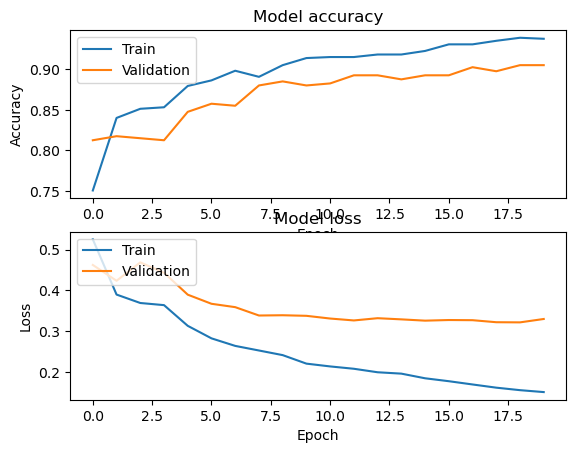

13/13 [==============================] - 1s 13ms/step
Confusion Matrix:
[[188  13]
 [ 25 174]]
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.94      0.91       201
           1       0.93      0.87      0.90       199

    accuracy                           0.91       400
   macro avg       0.91      0.90      0.90       400
weighted avg       0.91      0.91      0.90       400



In [43]:
# LSTM with learning rate (auto)
baseModel_LSTM(X_train, y_train, X_valid, y_valid, lr='auto', epochs=20)

Epoch 1/20
50/50 [==============================] - 11s 145ms/step - loss: 0.5410 - accuracy: 0.7663 - val_loss: 0.5226 - val_accuracy: 0.7275
Epoch 2/20
50/50 [==============================] - 6s 123ms/step - loss: 0.4957 - accuracy: 0.7812 - val_loss: 0.5097 - val_accuracy: 0.7700
Epoch 3/20
50/50 [==============================] - 6s 123ms/step - loss: 0.4795 - accuracy: 0.7900 - val_loss: 0.5267 - val_accuracy: 0.7375
Epoch 4/20
50/50 [==============================] - 6s 119ms/step - loss: 0.4460 - accuracy: 0.8144 - val_loss: 0.4949 - val_accuracy: 0.7800
Epoch 5/20
50/50 [==============================] - 6s 120ms/step - loss: 0.4649 - accuracy: 0.7937 - val_loss: 0.4345 - val_accuracy: 0.8075
Epoch 6/20
50/50 [==============================] - 6s 125ms/step - loss: 0.4122 - accuracy: 0.8294 - val_loss: 0.4432 - val_accuracy: 0.7950
Epoch 7/20
50/50 [==============================] - 6s 122ms/step - loss: 0.4329 - accuracy: 0.7944 - val_loss: 0.4450 - val_accuracy: 0.8175
Epoch

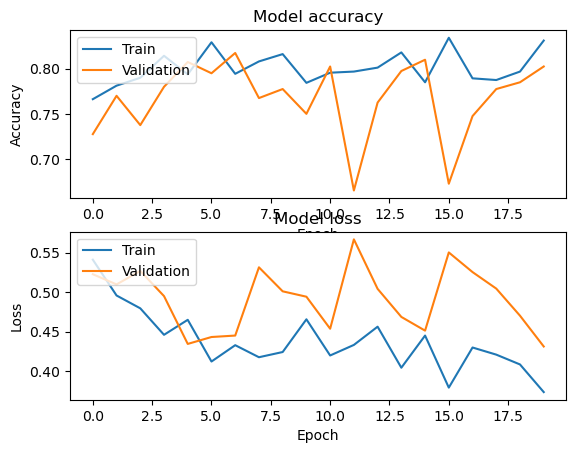

13/13 [==============================] - 1s 13ms/step
Confusion Matrix:
[[149  52]
 [ 27 172]]
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.74      0.79       201
           1       0.77      0.86      0.81       199

    accuracy                           0.80       400
   macro avg       0.81      0.80      0.80       400
weighted avg       0.81      0.80      0.80       400



In [44]:
# GRU with learning rate (0.01)
baseModel_GRU(X_train, y_train, X_valid, y_valid, lr=0.01, epochs=20)

Epoch 1/20
50/50 [==============================] - 12s 157ms/step - loss: 0.4791 - accuracy: 0.7869 - val_loss: 0.4348 - val_accuracy: 0.8300
Epoch 2/20
50/50 [==============================] - 7s 133ms/step - loss: 0.3536 - accuracy: 0.8650 - val_loss: 0.4066 - val_accuracy: 0.8550
Epoch 3/20
50/50 [==============================] - 7s 132ms/step - loss: 0.3204 - accuracy: 0.8706 - val_loss: 0.4076 - val_accuracy: 0.8625
Epoch 4/20
50/50 [==============================] - 7s 134ms/step - loss: 0.3242 - accuracy: 0.8769 - val_loss: 0.4237 - val_accuracy: 0.8575
Epoch 5/20
50/50 [==============================] - 6s 128ms/step - loss: 0.3421 - accuracy: 0.8581 - val_loss: 0.3862 - val_accuracy: 0.8700
Epoch 6/20
50/50 [==============================] - 7s 130ms/step - loss: 0.3029 - accuracy: 0.8856 - val_loss: 0.4160 - val_accuracy: 0.8575
Epoch 7/20
50/50 [==============================] - 6s 128ms/step - loss: 0.2863 - accuracy: 0.8900 - val_loss: 0.4361 - val_accuracy: 0.8325
Epoch

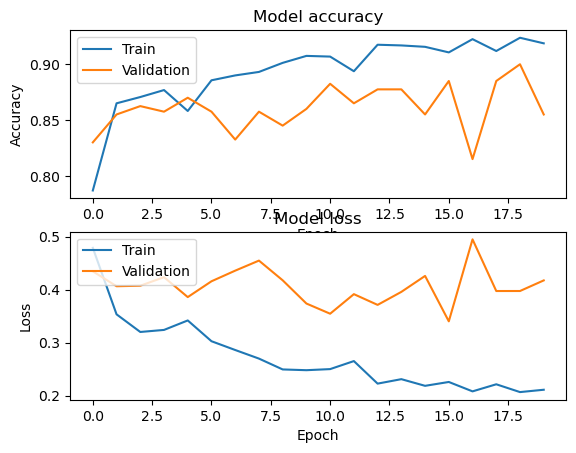

13/13 [==============================] - 1s 12ms/step
Confusion Matrix:
[[165  36]
 [ 22 177]]
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.82      0.85       201
           1       0.83      0.89      0.86       199

    accuracy                           0.85       400
   macro avg       0.86      0.86      0.85       400
weighted avg       0.86      0.85      0.85       400



In [45]:
# GRU with learning rate (0.001)
baseModel_GRU(X_train, y_train, X_valid, y_valid, lr=0.001, epochs=20)

Epoch 1/20
50/50 [==============================] - 13s 142ms/step - loss: 0.4558 - accuracy: 0.8206 - val_loss: 0.4102 - val_accuracy: 0.8450
Epoch 2/20
50/50 [==============================] - 6s 121ms/step - loss: 0.3333 - accuracy: 0.8825 - val_loss: 0.3443 - val_accuracy: 0.8950
Epoch 3/20
50/50 [==============================] - 6s 119ms/step - loss: 0.2599 - accuracy: 0.9119 - val_loss: 0.3054 - val_accuracy: 0.9000
Epoch 4/20
50/50 [==============================] - 6s 119ms/step - loss: 0.2219 - accuracy: 0.9169 - val_loss: 0.2943 - val_accuracy: 0.8975
Epoch 5/20
50/50 [==============================] - 6s 121ms/step - loss: 0.1725 - accuracy: 0.9381 - val_loss: 0.2707 - val_accuracy: 0.9025
Epoch 6/20
50/50 [==============================] - 6s 119ms/step - loss: 0.1543 - accuracy: 0.9431 - val_loss: 0.2696 - val_accuracy: 0.9050
Epoch 7/20
50/50 [==============================] - 6s 122ms/step - loss: 0.1320 - accuracy: 0.9550 - val_loss: 0.2492 - val_accuracy: 0.9175
Epoch

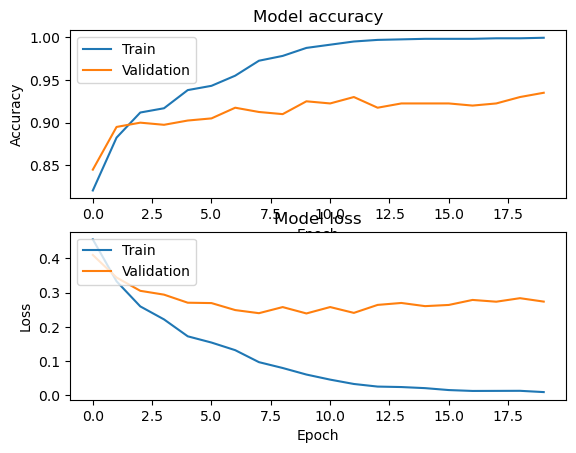

13/13 [==============================] - 1s 12ms/step
Confusion Matrix:
[[189  12]
 [ 14 185]]
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.94      0.94       201
           1       0.94      0.93      0.93       199

    accuracy                           0.94       400
   macro avg       0.94      0.93      0.93       400
weighted avg       0.94      0.94      0.93       400



In [46]:
# GRU with learning rate (0.0001)
baseModel_GRU(X_train, y_train, X_valid, y_valid, lr=0.0001, epochs=20)

Epoch 1/20
50/50 [==============================] - 12s 164ms/step - loss: 0.4883 - accuracy: 0.8000 - val_loss: 0.4538 - val_accuracy: 0.8075 - lr: 0.0010
Epoch 2/20
50/50 [==============================] - 7s 134ms/step - loss: 0.3926 - accuracy: 0.8400 - val_loss: 0.3927 - val_accuracy: 0.8500 - lr: 0.0010
Epoch 3/20
50/50 [==============================] - 6s 126ms/step - loss: 0.3625 - accuracy: 0.8450 - val_loss: 0.3826 - val_accuracy: 0.8750 - lr: 0.0010
Epoch 4/20
50/50 [==============================] - 6s 128ms/step - loss: 0.3665 - accuracy: 0.8469 - val_loss: 0.4101 - val_accuracy: 0.8225 - lr: 0.0010
Epoch 5/20
50/50 [==============================] - 6s 123ms/step - loss: 0.3328 - accuracy: 0.8637 - val_loss: 0.4694 - val_accuracy: 0.8200 - lr: 0.0010
Epoch 6/20
50/50 [==============================] - 6s 125ms/step - loss: 0.3126 - accuracy: 0.8838 - val_loss: 0.3966 - val_accuracy: 0.8650 - lr: 1.0000e-04
Epoch 7/20
50/50 [==============================] - 7s 130ms/step

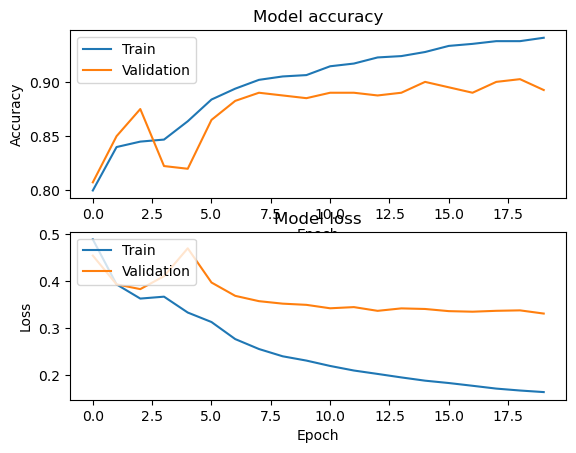

13/13 [==============================] - 1s 15ms/step
Confusion Matrix:
[[184  17]
 [ 26 173]]
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.92      0.90       201
           1       0.91      0.87      0.89       199

    accuracy                           0.89       400
   macro avg       0.89      0.89      0.89       400
weighted avg       0.89      0.89      0.89       400



In [47]:
# GRU with learning rate (auto)
baseModel_GRU(X_train, y_train, X_valid, y_valid, lr='auto', epochs=20)

Epoch 1/20
50/50 [==============================] - 37s 712ms/step - loss: 8.6158 - accuracy: 0.6694 - val_loss: 1.3891 - val_accuracy: 0.7500
Epoch 2/20
50/50 [==============================] - 33s 664ms/step - loss: 1.2312 - accuracy: 0.7837 - val_loss: 0.8916 - val_accuracy: 0.7650
Epoch 3/20
50/50 [==============================] - 33s 662ms/step - loss: 0.5803 - accuracy: 0.8294 - val_loss: 0.5210 - val_accuracy: 0.8600
Epoch 4/20
50/50 [==============================] - 33s 668ms/step - loss: 0.3744 - accuracy: 0.8675 - val_loss: 0.4400 - val_accuracy: 0.8750
Epoch 5/20
50/50 [==============================] - 30s 605ms/step - loss: 0.2376 - accuracy: 0.9087 - val_loss: 0.6186 - val_accuracy: 0.8775
Epoch 6/20
50/50 [==============================] - 30s 599ms/step - loss: 0.2472 - accuracy: 0.9062 - val_loss: 0.4922 - val_accuracy: 0.8200
Epoch 7/20
50/50 [==============================] - 31s 618ms/step - loss: 0.2529 - accuracy: 0.9175 - val_loss: 0.5366 - val_accuracy: 0.8225

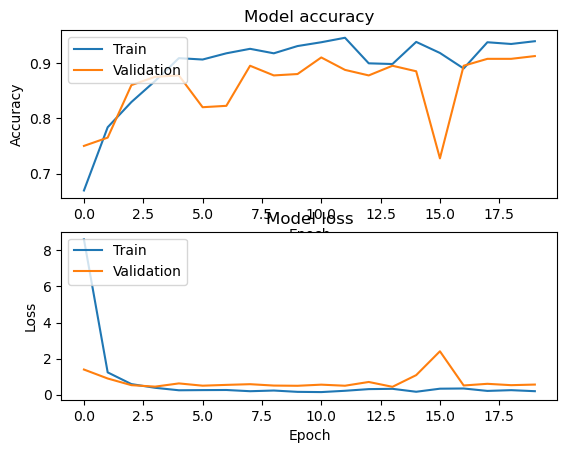

13/13 [==============================] - 0s 11ms/step
Confusion Matrix:
[[194   7]
 [ 28 171]]
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.97      0.92       201
           1       0.96      0.86      0.91       199

    accuracy                           0.91       400
   macro avg       0.92      0.91      0.91       400
weighted avg       0.92      0.91      0.91       400



In [48]:
# TCN with learning rate (0.01)
baseModel_TCN(X_train, y_train, X_valid, y_valid, lr=0.01, epochs=20)

Epoch 1/20
50/50 [==============================] - 31s 607ms/step - loss: 1.4929 - accuracy: 0.7487 - val_loss: 0.8241 - val_accuracy: 0.7600
Epoch 2/20
50/50 [==============================] - 30s 605ms/step - loss: 0.4146 - accuracy: 0.8725 - val_loss: 0.5678 - val_accuracy: 0.8025
Epoch 3/20
50/50 [==============================] - 31s 614ms/step - loss: 0.2611 - accuracy: 0.9094 - val_loss: 0.3589 - val_accuracy: 0.8925
Epoch 4/20
50/50 [==============================] - 30s 602ms/step - loss: 0.1321 - accuracy: 0.9544 - val_loss: 0.3882 - val_accuracy: 0.9125
Epoch 5/20
50/50 [==============================] - 33s 658ms/step - loss: 0.0870 - accuracy: 0.9712 - val_loss: 0.3226 - val_accuracy: 0.9200
Epoch 6/20
50/50 [==============================] - 33s 669ms/step - loss: 0.0474 - accuracy: 0.9850 - val_loss: 0.4272 - val_accuracy: 0.8975
Epoch 7/20
50/50 [==============================] - 32s 629ms/step - loss: 0.0399 - accuracy: 0.9906 - val_loss: 0.3992 - val_accuracy: 0.9100

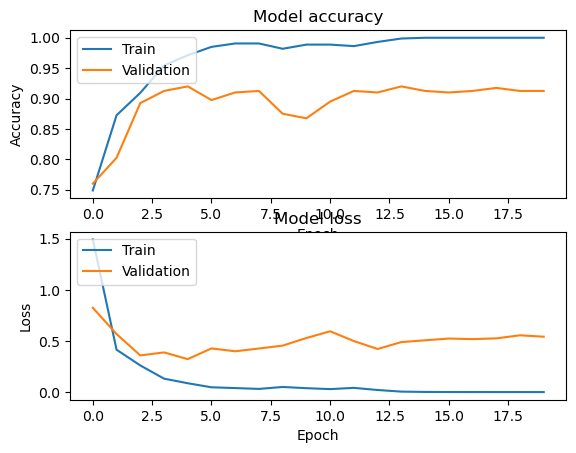

13/13 [==============================] - 0s 11ms/step
Confusion Matrix:
[[188  13]
 [ 22 177]]
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.94      0.91       201
           1       0.93      0.89      0.91       199

    accuracy                           0.91       400
   macro avg       0.91      0.91      0.91       400
weighted avg       0.91      0.91      0.91       400



In [49]:
# TCN with learning rate (0.001)
baseModel_TCN(X_train, y_train, X_valid, y_valid, lr=0.001, epochs=20)

Epoch 1/20
50/50 [==============================] - 31s 604ms/step - loss: 0.4696 - accuracy: 0.7944 - val_loss: 0.3812 - val_accuracy: 0.8375
Epoch 2/20
50/50 [==============================] - 32s 642ms/step - loss: 0.2671 - accuracy: 0.8950 - val_loss: 0.3793 - val_accuracy: 0.8775
Epoch 3/20
50/50 [==============================] - 34s 670ms/step - loss: 0.1677 - accuracy: 0.9431 - val_loss: 0.3669 - val_accuracy: 0.8650
Epoch 4/20
50/50 [==============================] - 33s 654ms/step - loss: 0.1338 - accuracy: 0.9581 - val_loss: 0.3157 - val_accuracy: 0.9075
Epoch 5/20
50/50 [==============================] - 32s 633ms/step - loss: 0.0848 - accuracy: 0.9756 - val_loss: 0.4283 - val_accuracy: 0.8475
Epoch 6/20
50/50 [==============================] - 30s 601ms/step - loss: 0.0859 - accuracy: 0.9725 - val_loss: 0.3739 - val_accuracy: 0.8800
Epoch 7/20
50/50 [==============================] - 30s 599ms/step - loss: 0.0631 - accuracy: 0.9850 - val_loss: 0.4406 - val_accuracy: 0.8950

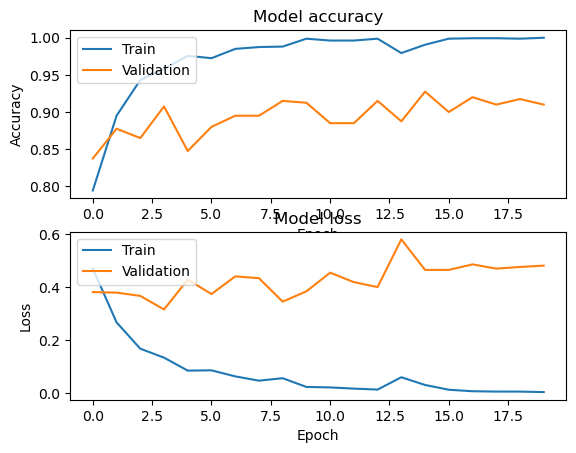

13/13 [==============================] - 0s 11ms/step
Confusion Matrix:
[[189  12]
 [ 24 175]]
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.94      0.91       201
           1       0.94      0.88      0.91       199

    accuracy                           0.91       400
   macro avg       0.91      0.91      0.91       400
weighted avg       0.91      0.91      0.91       400



In [50]:
# TCN with learning rate (0.0001)
baseModel_TCN(X_train, y_train, X_valid, y_valid, lr=0.0001, epochs=20)

Epoch 1/20
50/50 [==============================] - 31s 609ms/step - loss: 1.0005 - accuracy: 0.7781 - val_loss: 0.5457 - val_accuracy: 0.8150 - lr: 0.0010
Epoch 2/20
50/50 [==============================] - 30s 607ms/step - loss: 0.5396 - accuracy: 0.8675 - val_loss: 0.5364 - val_accuracy: 0.8525 - lr: 0.0010
Epoch 3/20
50/50 [==============================] - 30s 604ms/step - loss: 0.4381 - accuracy: 0.8800 - val_loss: 0.5666 - val_accuracy: 0.8350 - lr: 0.0010
Epoch 4/20
50/50 [==============================] - 33s 655ms/step - loss: 0.1814 - accuracy: 0.9513 - val_loss: 0.4246 - val_accuracy: 0.8825 - lr: 0.0010
Epoch 5/20
50/50 [==============================] - 31s 613ms/step - loss: 0.1264 - accuracy: 0.9569 - val_loss: 0.8031 - val_accuracy: 0.8225 - lr: 0.0010
Epoch 6/20
50/50 [==============================] - 34s 671ms/step - loss: 0.1014 - accuracy: 0.9663 - val_loss: 0.4622 - val_accuracy: 0.8950 - lr: 0.0010
Epoch 7/20
50/50 [==============================] - 32s 635ms/st

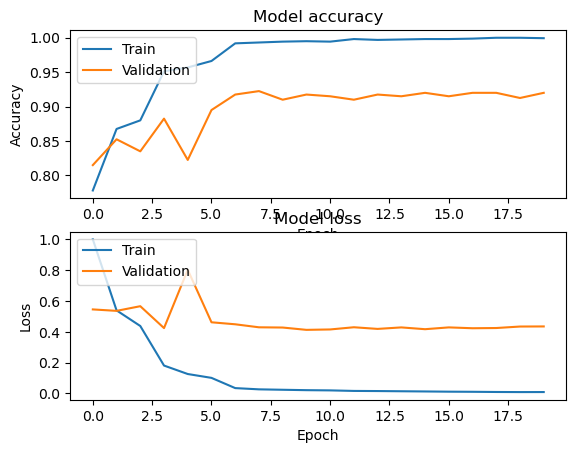

13/13 [==============================] - 0s 10ms/step
Confusion Matrix:
[[189  12]
 [ 20 179]]
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.94      0.92       201
           1       0.94      0.90      0.92       199

    accuracy                           0.92       400
   macro avg       0.92      0.92      0.92       400
weighted avg       0.92      0.92      0.92       400



In [51]:
# TCN with learning rate (auto)
baseModel_TCN(X_train, y_train, X_valid, y_valid, lr='auto', epochs=20)

Epoch 1/30
50/50 [==============================] - 12s 179ms/step - loss: 0.5376 - accuracy: 0.7481 - val_loss: 0.5296 - val_accuracy: 0.7550
Epoch 2/30
50/50 [==============================] - 9s 177ms/step - loss: 0.4860 - accuracy: 0.7950 - val_loss: 0.4738 - val_accuracy: 0.8075
Epoch 3/30
50/50 [==============================] - 8s 156ms/step - loss: 0.4599 - accuracy: 0.7925 - val_loss: 0.5007 - val_accuracy: 0.7850
Epoch 4/30
50/50 [==============================] - 8s 158ms/step - loss: 0.4397 - accuracy: 0.7987 - val_loss: 0.4572 - val_accuracy: 0.8025
Epoch 5/30
50/50 [==============================] - 8s 160ms/step - loss: 0.4278 - accuracy: 0.8050 - val_loss: 0.5296 - val_accuracy: 0.7550
Epoch 6/30
50/50 [==============================] - 8s 153ms/step - loss: 0.4299 - accuracy: 0.7994 - val_loss: 0.5341 - val_accuracy: 0.7625
Epoch 7/30
50/50 [==============================] - 8s 160ms/step - loss: 0.4158 - accuracy: 0.8306 - val_loss: 0.4671 - val_accuracy: 0.8150
Epoch

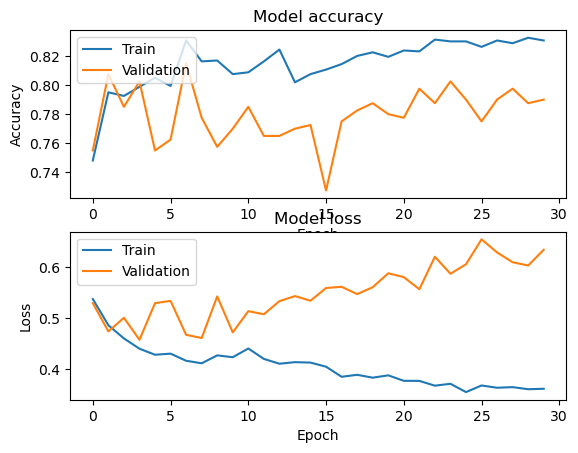

13/13 [==============================] - 1s 11ms/step
Confusion Matrix:
[[140  61]
 [ 23 176]]
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.70      0.77       201
           1       0.74      0.88      0.81       199

    accuracy                           0.79       400
   macro avg       0.80      0.79      0.79       400
weighted avg       0.80      0.79      0.79       400



In [7]:
# LSTM with learning rate (0.01)
baseModel_LSTM(X_train, y_train, X_valid, y_valid, lr=0.01, epochs=30)

Epoch 1/30
50/50 [==============================] - 14s 190ms/step - loss: 0.5198 - accuracy: 0.7462 - val_loss: 0.4493 - val_accuracy: 0.8475
Epoch 2/30
50/50 [==============================] - 8s 163ms/step - loss: 0.3682 - accuracy: 0.8631 - val_loss: 0.3977 - val_accuracy: 0.8550
Epoch 3/30
50/50 [==============================] - 8s 163ms/step - loss: 0.3174 - accuracy: 0.8813 - val_loss: 0.4448 - val_accuracy: 0.8150
Epoch 4/30
50/50 [==============================] - 8s 157ms/step - loss: 0.3521 - accuracy: 0.8581 - val_loss: 0.3887 - val_accuracy: 0.8500
Epoch 5/30
50/50 [==============================] - 8s 170ms/step - loss: 0.3297 - accuracy: 0.8719 - val_loss: 0.3919 - val_accuracy: 0.8450
Epoch 6/30
50/50 [==============================] - 8s 162ms/step - loss: 0.3165 - accuracy: 0.8763 - val_loss: 0.4136 - val_accuracy: 0.8575
Epoch 7/30
50/50 [==============================] - 8s 162ms/step - loss: 0.3149 - accuracy: 0.8788 - val_loss: 0.4176 - val_accuracy: 0.8250
Epoch

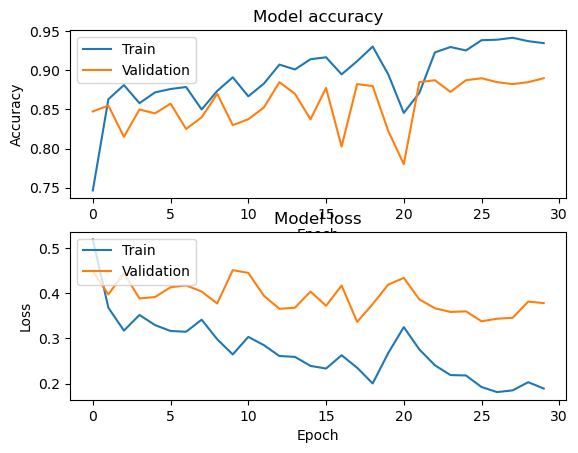

13/13 [==============================] - 1s 16ms/step
Confusion Matrix:
[[187  14]
 [ 30 169]]
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.93      0.89       201
           1       0.92      0.85      0.88       199

    accuracy                           0.89       400
   macro avg       0.89      0.89      0.89       400
weighted avg       0.89      0.89      0.89       400



In [8]:
# LSTM with learning rate (0.001)
baseModel_LSTM(X_train, y_train, X_valid, y_valid, lr=0.001, epochs=30)

Epoch 1/30
50/50 [==============================] - 16s 225ms/step - loss: 0.5012 - accuracy: 0.8156 - val_loss: 0.4565 - val_accuracy: 0.8675
Epoch 2/30
50/50 [==============================] - 9s 184ms/step - loss: 0.3836 - accuracy: 0.8775 - val_loss: 0.3970 - val_accuracy: 0.8650
Epoch 3/30
50/50 [==============================] - 8s 170ms/step - loss: 0.3051 - accuracy: 0.9056 - val_loss: 0.3381 - val_accuracy: 0.8975
Epoch 4/30
50/50 [==============================] - 8s 168ms/step - loss: 0.2524 - accuracy: 0.9175 - val_loss: 0.3486 - val_accuracy: 0.8775
Epoch 5/30
50/50 [==============================] - 8s 165ms/step - loss: 0.2141 - accuracy: 0.9275 - val_loss: 0.2996 - val_accuracy: 0.9075
Epoch 6/30
50/50 [==============================] - 9s 173ms/step - loss: 0.1789 - accuracy: 0.9388 - val_loss: 0.2787 - val_accuracy: 0.9100
Epoch 7/30
50/50 [==============================] - 9s 184ms/step - loss: 0.1616 - accuracy: 0.9500 - val_loss: 0.2723 - val_accuracy: 0.9075
Epoch

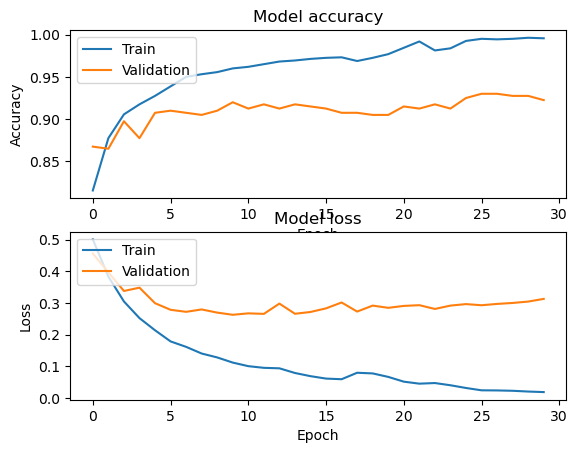

13/13 [==============================] - 1s 12ms/step
Confusion Matrix:
[[190  11]
 [ 20 179]]
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.95      0.92       201
           1       0.94      0.90      0.92       199

    accuracy                           0.92       400
   macro avg       0.92      0.92      0.92       400
weighted avg       0.92      0.92      0.92       400



In [9]:
# LSTM with learning rate (0.0001)
baseModel_LSTM(X_train, y_train, X_valid, y_valid, lr=0.0001, epochs=30)

Epoch 1/30
50/50 [==============================] - 13s 175ms/step - loss: 0.4881 - accuracy: 0.7837 - val_loss: 0.4324 - val_accuracy: 0.8250 - lr: 0.0010
Epoch 2/30
50/50 [==============================] - 8s 153ms/step - loss: 0.3823 - accuracy: 0.8481 - val_loss: 0.4140 - val_accuracy: 0.8400 - lr: 0.0010
Epoch 3/30
50/50 [==============================] - 8s 155ms/step - loss: 0.3766 - accuracy: 0.8400 - val_loss: 0.3963 - val_accuracy: 0.8475 - lr: 0.0010
Epoch 4/30
50/50 [==============================] - 8s 154ms/step - loss: 0.3576 - accuracy: 0.8438 - val_loss: 0.4239 - val_accuracy: 0.8250 - lr: 0.0010
Epoch 5/30
50/50 [==============================] - 8s 158ms/step - loss: 0.3318 - accuracy: 0.8725 - val_loss: 0.3898 - val_accuracy: 0.8750 - lr: 0.0010
Epoch 6/30
50/50 [==============================] - 8s 157ms/step - loss: 0.2909 - accuracy: 0.8875 - val_loss: 0.3934 - val_accuracy: 0.8550 - lr: 0.0010
Epoch 7/30
50/50 [==============================] - 8s 161ms/step - l

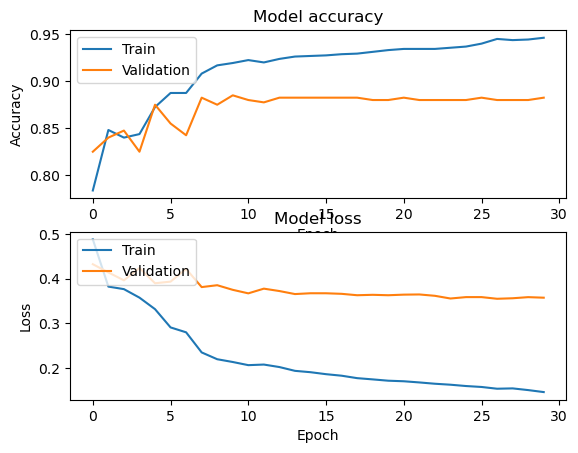

13/13 [==============================] - 1s 14ms/step
Confusion Matrix:
[[184  17]
 [ 30 169]]
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.92      0.89       201
           1       0.91      0.85      0.88       199

    accuracy                           0.88       400
   macro avg       0.88      0.88      0.88       400
weighted avg       0.88      0.88      0.88       400



In [10]:
# LSTM with learning rate (auto)
baseModel_LSTM(X_train, y_train, X_valid, y_valid, lr='auto', epochs=30)

Epoch 1/30
50/50 [==============================] - 10s 131ms/step - loss: 0.5283 - accuracy: 0.7462 - val_loss: 0.5194 - val_accuracy: 0.7675
Epoch 2/30
50/50 [==============================] - 6s 116ms/step - loss: 0.4921 - accuracy: 0.7800 - val_loss: 0.4652 - val_accuracy: 0.7700
Epoch 3/30
50/50 [==============================] - 8s 153ms/step - loss: 0.4803 - accuracy: 0.7713 - val_loss: 0.5136 - val_accuracy: 0.7250
Epoch 4/30
50/50 [==============================] - 6s 128ms/step - loss: 0.4641 - accuracy: 0.7825 - val_loss: 0.5159 - val_accuracy: 0.7600
Epoch 5/30
50/50 [==============================] - 6s 120ms/step - loss: 0.4548 - accuracy: 0.8075 - val_loss: 0.4799 - val_accuracy: 0.7875
Epoch 6/30
50/50 [==============================] - 6s 120ms/step - loss: 0.4484 - accuracy: 0.8075 - val_loss: 0.5152 - val_accuracy: 0.7300
Epoch 7/30
50/50 [==============================] - 6s 119ms/step - loss: 0.4850 - accuracy: 0.7669 - val_loss: 0.4937 - val_accuracy: 0.7600
Epoch

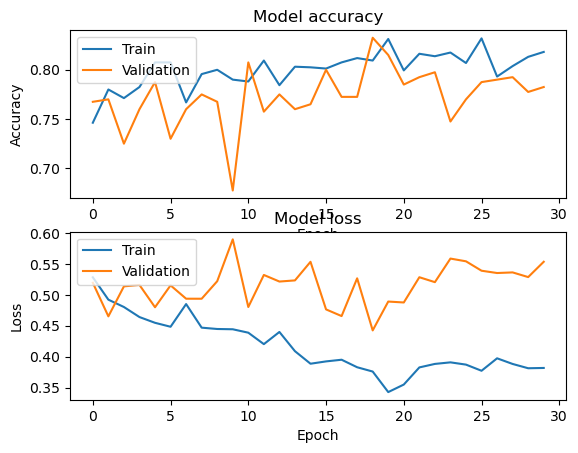

13/13 [==============================] - 2s 24ms/step
Confusion Matrix:
[[142  59]
 [ 28 171]]
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.71      0.77       201
           1       0.74      0.86      0.80       199

    accuracy                           0.78       400
   macro avg       0.79      0.78      0.78       400
weighted avg       0.79      0.78      0.78       400



In [11]:
# GRU with learning rate (0.01)
baseModel_GRU(X_train, y_train, X_valid, y_valid, lr=0.01, epochs=30)

Epoch 1/30
50/50 [==============================] - 13s 148ms/step - loss: 0.4450 - accuracy: 0.8125 - val_loss: 0.4140 - val_accuracy: 0.8575
Epoch 2/30
50/50 [==============================] - 7s 140ms/step - loss: 0.3492 - accuracy: 0.8675 - val_loss: 0.3826 - val_accuracy: 0.8625
Epoch 3/30
50/50 [==============================] - 6s 126ms/step - loss: 0.3517 - accuracy: 0.8612 - val_loss: 0.3963 - val_accuracy: 0.8425
Epoch 4/30
50/50 [==============================] - 7s 132ms/step - loss: 0.3425 - accuracy: 0.8531 - val_loss: 0.3983 - val_accuracy: 0.8500
Epoch 5/30
50/50 [==============================] - 6s 126ms/step - loss: 0.3493 - accuracy: 0.8369 - val_loss: 0.4078 - val_accuracy: 0.8475
Epoch 6/30
50/50 [==============================] - 6s 126ms/step - loss: 0.3289 - accuracy: 0.8625 - val_loss: 0.3870 - val_accuracy: 0.8525
Epoch 7/30
50/50 [==============================] - 6s 129ms/step - loss: 0.3019 - accuracy: 0.8788 - val_loss: 0.3640 - val_accuracy: 0.8450
Epoch

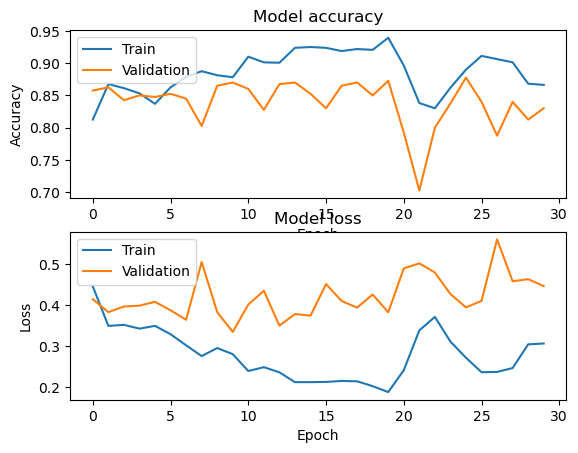

13/13 [==============================] - 1s 13ms/step
Confusion Matrix:
[[187  14]
 [ 54 145]]
Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.93      0.85       201
           1       0.91      0.73      0.81       199

    accuracy                           0.83       400
   macro avg       0.84      0.83      0.83       400
weighted avg       0.84      0.83      0.83       400



In [12]:
# GRU with learning rate (0.001)
baseModel_GRU(X_train, y_train, X_valid, y_valid, lr=0.001, epochs=30)

Epoch 1/30
50/50 [==============================] - 10s 140ms/step - loss: 0.4517 - accuracy: 0.8119 - val_loss: 0.4102 - val_accuracy: 0.8375
Epoch 2/30
50/50 [==============================] - 6s 122ms/step - loss: 0.3136 - accuracy: 0.8944 - val_loss: 0.3284 - val_accuracy: 0.8975
Epoch 3/30
50/50 [==============================] - 6s 119ms/step - loss: 0.2514 - accuracy: 0.9137 - val_loss: 0.3021 - val_accuracy: 0.9025
Epoch 4/30
50/50 [==============================] - 6s 119ms/step - loss: 0.2067 - accuracy: 0.9275 - val_loss: 0.3217 - val_accuracy: 0.8650
Epoch 5/30
50/50 [==============================] - 6s 119ms/step - loss: 0.1817 - accuracy: 0.9356 - val_loss: 0.2859 - val_accuracy: 0.9000
Epoch 6/30
50/50 [==============================] - 6s 129ms/step - loss: 0.1526 - accuracy: 0.9481 - val_loss: 0.3142 - val_accuracy: 0.8725
Epoch 7/30
50/50 [==============================] - 9s 183ms/step - loss: 0.1314 - accuracy: 0.9525 - val_loss: 0.2673 - val_accuracy: 0.9100
Epoch

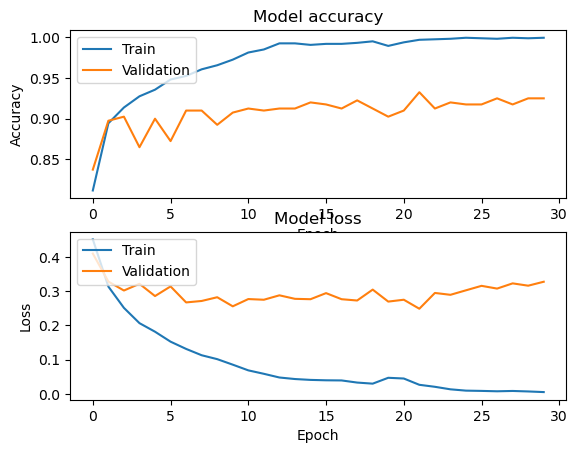

13/13 [==============================] - 1s 11ms/step
Confusion Matrix:
[[189  12]
 [ 18 181]]
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.94      0.93       201
           1       0.94      0.91      0.92       199

    accuracy                           0.93       400
   macro avg       0.93      0.92      0.92       400
weighted avg       0.93      0.93      0.92       400



In [13]:
# GRU with learning rate (0.0001)
baseModel_GRU(X_train, y_train, X_valid, y_valid, lr=0.0001, epochs=30)

Epoch 1/30
50/50 [==============================] - 12s 150ms/step - loss: 0.4862 - accuracy: 0.7769 - val_loss: 0.4426 - val_accuracy: 0.8375 - lr: 0.0010
Epoch 2/30
50/50 [==============================] - 6s 129ms/step - loss: 0.3822 - accuracy: 0.8438 - val_loss: 0.4245 - val_accuracy: 0.8400 - lr: 0.0010
Epoch 3/30
50/50 [==============================] - 6s 123ms/step - loss: 0.3465 - accuracy: 0.8625 - val_loss: 0.4062 - val_accuracy: 0.8450 - lr: 0.0010
Epoch 4/30
50/50 [==============================] - 6s 130ms/step - loss: 0.3422 - accuracy: 0.8575 - val_loss: 0.4093 - val_accuracy: 0.8475 - lr: 0.0010
Epoch 5/30
50/50 [==============================] - 6s 124ms/step - loss: 0.3327 - accuracy: 0.8700 - val_loss: 0.4048 - val_accuracy: 0.8550 - lr: 0.0010
Epoch 6/30
50/50 [==============================] - 7s 142ms/step - loss: 0.3556 - accuracy: 0.8475 - val_loss: 0.4146 - val_accuracy: 0.8450 - lr: 0.0010
Epoch 7/30
50/50 [==============================] - 7s 149ms/step - l

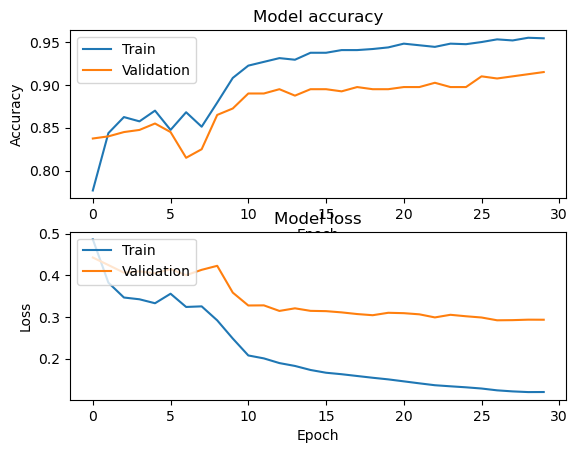

13/13 [==============================] - 2s 11ms/step
Confusion Matrix:
[[188  13]
 [ 21 178]]
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.94      0.92       201
           1       0.93      0.89      0.91       199

    accuracy                           0.92       400
   macro avg       0.92      0.91      0.91       400
weighted avg       0.92      0.92      0.91       400



In [14]:
# GRU with learning rate (auto)
baseModel_GRU(X_train, y_train, X_valid, y_valid, lr='auto', epochs=30)

Epoch 1/30
50/50 [==============================] - 34s 663ms/step - loss: 8.8499 - accuracy: 0.6900 - val_loss: 1.3293 - val_accuracy: 0.6825
Epoch 2/30
50/50 [==============================] - 29s 580ms/step - loss: 0.7647 - accuracy: 0.8138 - val_loss: 0.5716 - val_accuracy: 0.8525
Epoch 3/30
50/50 [==============================] - 30s 590ms/step - loss: 0.4352 - accuracy: 0.8450 - val_loss: 0.5056 - val_accuracy: 0.7975
Epoch 4/30
50/50 [==============================] - 30s 600ms/step - loss: 0.3058 - accuracy: 0.9019 - val_loss: 0.4779 - val_accuracy: 0.9025
Epoch 5/30
50/50 [==============================] - 29s 589ms/step - loss: 0.1708 - accuracy: 0.9375 - val_loss: 0.4250 - val_accuracy: 0.9075
Epoch 6/30
50/50 [==============================] - 30s 598ms/step - loss: 0.1084 - accuracy: 0.9631 - val_loss: 0.3668 - val_accuracy: 0.9150
Epoch 7/30
50/50 [==============================] - 30s 590ms/step - loss: 0.0545 - accuracy: 0.9831 - val_loss: 0.3746 - val_accuracy: 0.9275

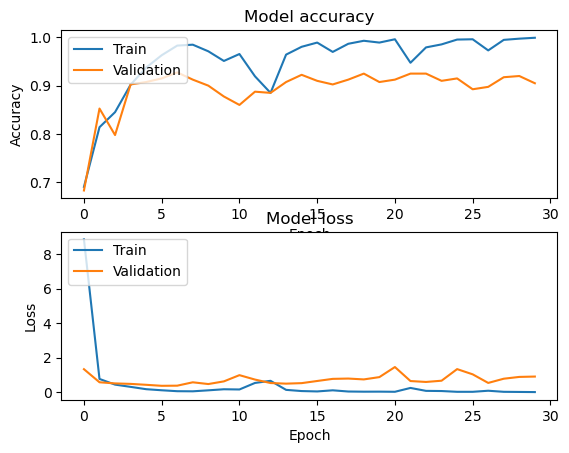

13/13 [==============================] - 0s 12ms/step
Confusion Matrix:
[[189  12]
 [ 26 173]]
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.94      0.91       201
           1       0.94      0.87      0.90       199

    accuracy                           0.91       400
   macro avg       0.91      0.90      0.90       400
weighted avg       0.91      0.91      0.90       400



In [15]:
# TCN with learning rate (0.01)
baseModel_TCN(X_train, y_train, X_valid, y_valid, lr=0.01, epochs=30)

Epoch 1/30
50/50 [==============================] - 35s 668ms/step - loss: 1.0438 - accuracy: 0.7700 - val_loss: 0.8829 - val_accuracy: 0.8700
Epoch 2/30
50/50 [==============================] - 32s 647ms/step - loss: 0.7830 - accuracy: 0.8525 - val_loss: 1.0016 - val_accuracy: 0.8450
Epoch 3/30
50/50 [==============================] - 32s 649ms/step - loss: 0.3877 - accuracy: 0.9094 - val_loss: 0.4951 - val_accuracy: 0.8925
Epoch 4/30
50/50 [==============================] - 30s 591ms/step - loss: 0.1899 - accuracy: 0.9594 - val_loss: 0.4164 - val_accuracy: 0.8950
Epoch 5/30
50/50 [==============================] - 29s 582ms/step - loss: 0.2088 - accuracy: 0.9331 - val_loss: 0.5057 - val_accuracy: 0.8950
Epoch 6/30
50/50 [==============================] - 29s 584ms/step - loss: 0.0952 - accuracy: 0.9619 - val_loss: 0.5917 - val_accuracy: 0.8725
Epoch 7/30
50/50 [==============================] - 30s 591ms/step - loss: 0.0432 - accuracy: 0.9856 - val_loss: 0.4335 - val_accuracy: 0.9200

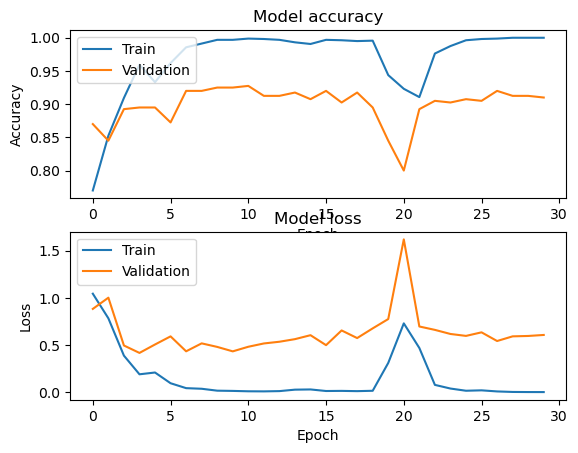

13/13 [==============================] - 0s 12ms/step
Confusion Matrix:
[[189  12]
 [ 24 175]]
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.94      0.91       201
           1       0.94      0.88      0.91       199

    accuracy                           0.91       400
   macro avg       0.91      0.91      0.91       400
weighted avg       0.91      0.91      0.91       400



In [16]:
# TCN with learning rate (0.001)
baseModel_TCN(X_train, y_train, X_valid, y_valid, lr=0.001, epochs=30)

Epoch 1/30
50/50 [==============================] - 39s 741ms/step - loss: 0.4683 - accuracy: 0.8012 - val_loss: 0.4125 - val_accuracy: 0.8425
Epoch 2/30
50/50 [==============================] - 49s 977ms/step - loss: 0.2609 - accuracy: 0.9069 - val_loss: 0.3467 - val_accuracy: 0.8850
Epoch 3/30
50/50 [==============================] - 50s 998ms/step - loss: 0.1988 - accuracy: 0.9262 - val_loss: 0.3068 - val_accuracy: 0.9150
Epoch 4/30
50/50 [==============================] - 48s 963ms/step - loss: 0.1289 - accuracy: 0.9638 - val_loss: 0.3309 - val_accuracy: 0.9050
Epoch 5/30
50/50 [==============================] - 48s 961ms/step - loss: 0.0940 - accuracy: 0.9737 - val_loss: 0.2967 - val_accuracy: 0.9150
Epoch 6/30
50/50 [==============================] - 41s 827ms/step - loss: 0.0659 - accuracy: 0.9862 - val_loss: 0.3053 - val_accuracy: 0.9175
Epoch 7/30
50/50 [==============================] - 39s 775ms/step - loss: 0.0526 - accuracy: 0.9894 - val_loss: 0.3250 - val_accuracy: 0.9000

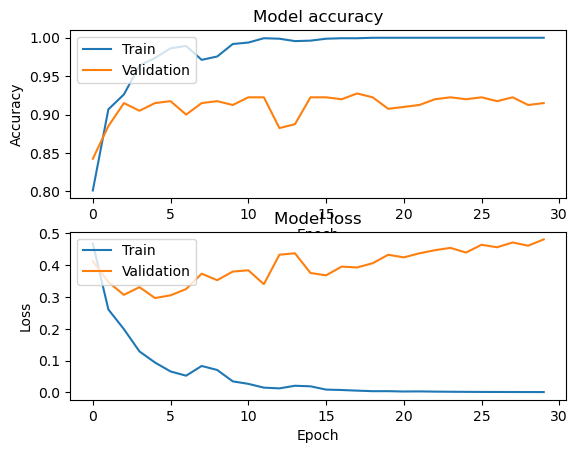

13/13 [==============================] - 0s 10ms/step
Confusion Matrix:
[[191  10]
 [ 24 175]]
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.95      0.92       201
           1       0.95      0.88      0.91       199

    accuracy                           0.92       400
   macro avg       0.92      0.91      0.91       400
weighted avg       0.92      0.92      0.91       400



In [17]:
# TCN with learning rate (0.0001)
baseModel_TCN(X_train, y_train, X_valid, y_valid, lr=0.0001, epochs=30)

Epoch 1/30
50/50 [==============================] - 34s 649ms/step - loss: 1.2985 - accuracy: 0.7756 - val_loss: 1.2590 - val_accuracy: 0.8225 - lr: 0.0010
Epoch 2/30
50/50 [==============================] - 32s 646ms/step - loss: 0.4566 - accuracy: 0.8975 - val_loss: 0.7377 - val_accuracy: 0.8250 - lr: 0.0010
Epoch 3/30
50/50 [==============================] - 33s 651ms/step - loss: 0.2270 - accuracy: 0.9331 - val_loss: 0.4905 - val_accuracy: 0.9000 - lr: 0.0010
Epoch 4/30
50/50 [==============================] - 33s 668ms/step - loss: 0.2149 - accuracy: 0.9513 - val_loss: 0.5186 - val_accuracy: 0.8675 - lr: 0.0010
Epoch 5/30
50/50 [==============================] - 32s 649ms/step - loss: 0.1132 - accuracy: 0.9594 - val_loss: 0.4892 - val_accuracy: 0.9025 - lr: 0.0010
Epoch 6/30
50/50 [==============================] - 32s 631ms/step - loss: 0.0741 - accuracy: 0.9762 - val_loss: 0.6381 - val_accuracy: 0.8825 - lr: 0.0010
Epoch 7/30
50/50 [==============================] - 34s 675ms/st

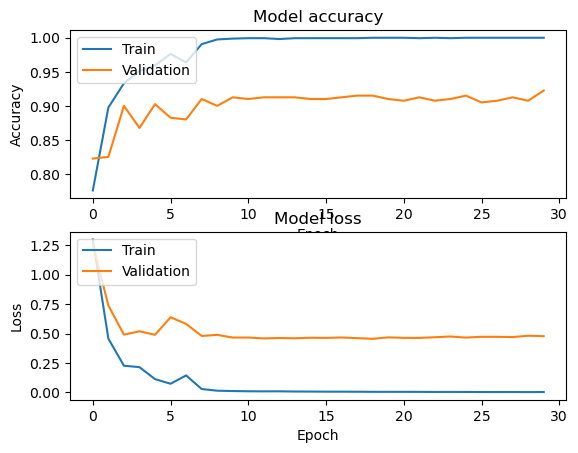

13/13 [==============================] - 0s 9ms/step
Confusion Matrix:
[[190  11]
 [ 20 179]]
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.95      0.92       201
           1       0.94      0.90      0.92       199

    accuracy                           0.92       400
   macro avg       0.92      0.92      0.92       400
weighted avg       0.92      0.92      0.92       400



In [18]:
# TCN with learning rate (auto)
baseModel_TCN(X_train, y_train, X_valid, y_valid, lr='auto', epochs=30)